# Particle marginal Metropolis-Hastings (PMMH)

Notebook about testing PMMH.

In [104]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

# Add parent directory to sys.path
print(os.getcwd())
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

d:\School\Fakulteta\2. stopnja\2. letnik\Master\notebooks


In [105]:
from src.models.lgm import LGModelParams, LGModel
from src.filters.kalman.kalman_filter import KalmanFilter
from src.filters.pmcmc.pmmh import ParticleMarginalMetropolisHastings
from src.filters.smc.bootstrap_pf import BootstrapParticleFilter
from src.filters.smc.auxiliary_pf import AuxiliaryParticleFilter
from src.filters.smc.resampling import systematic_resampling
from src.data_generation.simulate_data import simulate_data

In [106]:
# Set random seed for reproducibility
rng = np.random.default_rng(123)

# True parameters
true_theta = LGModelParams(
    a=0.7,
    b=1.0,
    sigma_x=0.6,
    sigma_y=0.8
)

# Initialize model
model = LGModel(rng=rng)

In [107]:
T = 100

x_true, y = simulate_data(model, true_theta, T, rng)

In [108]:
x_true = [x.x_t for x in x_true]  # Extract state values from State objects
x_true = np.array(x_true)
print(x_true.shape)
print(y.shape)

(100, 1)
(100, 1)


In [109]:
# Just checking the true log marginal likelihood for the true parameters from the Kalman filter
kf = KalmanFilter()
logmarlik_kf = kf.log_marginal_likelihood(y, true_theta)
mu_smooth, var_smooth = kf.smoother(y, true_theta)
print(f"Kalman filter log marginal likelihood: {logmarlik_kf}")
print(f"Kalman filter marginal likelihood: {np.exp(logmarlik_kf)}")

Kalman filter log marginal likelihood: -146.4524462884645
Kalman filter marginal likelihood: 2.4917858522770288e-64


First, we will use Bootstrap Particle Filter (BPF) as the underlying particle filter in PMMH. We will set the number of particles to $N = 1000$. We could increase this number to ensure even better approximation of the likelihood, but as we will see, even with $N = 1000$ particles, the variance of the likelihood estimates is sufficiently low to allow for good convergence of PMMH.

In [110]:
N = 1000

bpf = BootstrapParticleFilter(model, N, resampler=systematic_resampling)

In [111]:
# Test log marginal likelihood mean and variance for fixed parameters
logmarliks_bpf = []
for _ in range(1000): 
    history = bpf.run(y, true_theta)
    logmarlik = history[-1][3]
    logmarliks_bpf.append(logmarlik)

print(f"BPF log marginal likelihood")
print(f"mean: {np.mean(logmarliks_bpf)}")
print(f"variance: {np.var(logmarliks_bpf)}")

print(f"\nBPF marginal likelihood")
print(f"mean: {np.mean(np.exp(logmarliks_bpf))}")
print(f"variance: {np.var(np.exp(logmarliks_bpf))}")

BPF log marginal likelihood
mean: -146.33043731946415
variance: 0.07356785010870567

BPF marginal likelihood
mean: 2.9195404704105704e-64
variance: 6.342728330806173e-129


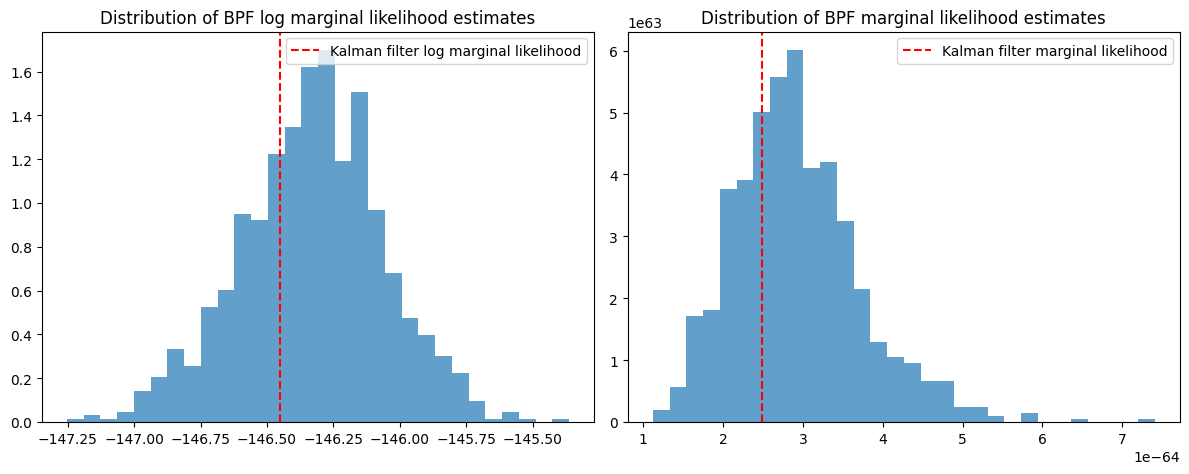

In [112]:
# Plot distribution of marginal likelihood estimates
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(logmarliks_bpf, bins=30, density=True, alpha=0.7)
plt.axvline(logmarlik_kf, color='red', linestyle='--', label='Kalman filter log marginal likelihood')
plt.title("Distribution of BPF log marginal likelihood estimates")
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(np.exp(logmarliks_bpf), bins=30, density=True, alpha=0.7)
plt.axvline(np.exp(logmarlik_kf), color='red', linestyle='--', label='Kalman filter marginal likelihood')
plt.title("Distribution of BPF marginal likelihood estimates")
plt.legend()
plt.tight_layout()
plt.show()

In [114]:
kwargs_for_sampling = {
    "step_a": 0.05,
    "step_b": 0.15,
    "step_sigma_x": 0.2,
    "step_sigma_y": 0.2,
}
    
pmmh = ParticleMarginalMetropolisHastings(bpf, kwargs_for_sampling=kwargs_for_sampling)

In [115]:
n_chains = 8
results_bpf = pmmh.run(y, n_iter=10000, n_chain=n_chains, burnin=0)

Chain 1 acceptance rate: 0.165
Chain 2 acceptance rate: 0.316
Chain 3 acceptance rate: 0.338
Chain 4 acceptance rate: 0.338
Chain 5 acceptance rate: 0.342
Chain 6 acceptance rate: 0.322
Chain 7 acceptance rate: 0.340
Chain 8 acceptance rate: 0.338


In [116]:
burn_in = 3000

In [117]:
# Print initial parameters theta for each chain
for chain in range(n_chains):
    _, _, thetas, _ = results_bpf[chain]
    initial_theta = {key: values[0] for key, values in thetas.items()}
    print(f"Chain {chain+1} initial theta: {initial_theta}")

Chain 1 initial theta: {'a': np.float64(-0.9891551717209247), 'b': 0.744444130753411, 'sigma_x': np.float64(1.4069636889391246), 'sigma_y': np.float64(0.21750564903580538)}
Chain 2 initial theta: {'a': 0.7601098874256116, 'b': -1.024813858271036, 'sigma_x': 1.0110897173240208, 'sigma_y': 0.0027767491673748664}
Chain 3 initial theta: {'a': np.float64(0.21275435625242406), 'b': -0.7611359680948467, 'sigma_x': np.float64(0.07942100520343938), 'sigma_y': np.float64(0.04023471773070648)}
Chain 4 initial theta: {'a': 0.28760818178136804, 'b': 1.2978533495957867, 'sigma_x': 1.3754852919197424, 'sigma_y': 2.2297464603804196}
Chain 5 initial theta: {'a': 0.13704515927708272, 'b': 0.9761364417195887, 'sigma_x': 0.12209199411532187, 'sigma_y': 0.7631438597092836}
Chain 6 initial theta: {'a': 0.7165160998247497, 'b': -1.1383748574002384, 'sigma_x': 0.2987812623130615, 'sigma_y': 0.013569643046891807}
Chain 7 initial theta: {'a': 0.0685661923883103, 'b': 1.133537274961927, 'sigma_x': 1.426092703586

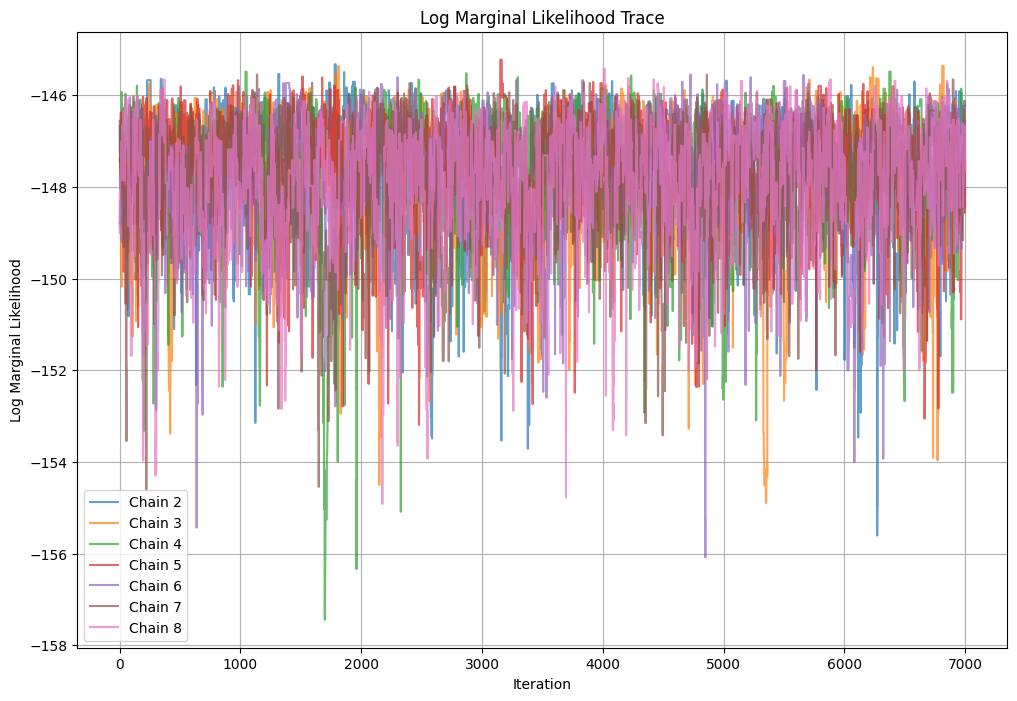

In [121]:
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    if chain == 0:
        continue       # Skip the 1st chain which seems to have diverged
    samples, logmarliks, thetas, alphas = results_bpf[chain]
    plt.plot(logmarliks[burn_in:], label=f"Chain {chain+1}", alpha=0.7)
    
plt.xlabel("Iteration")
plt.ylabel("Log Marginal Likelihood")
plt.title("Log Marginal Likelihood Trace")
plt.legend()
plt.grid()
plt.show()

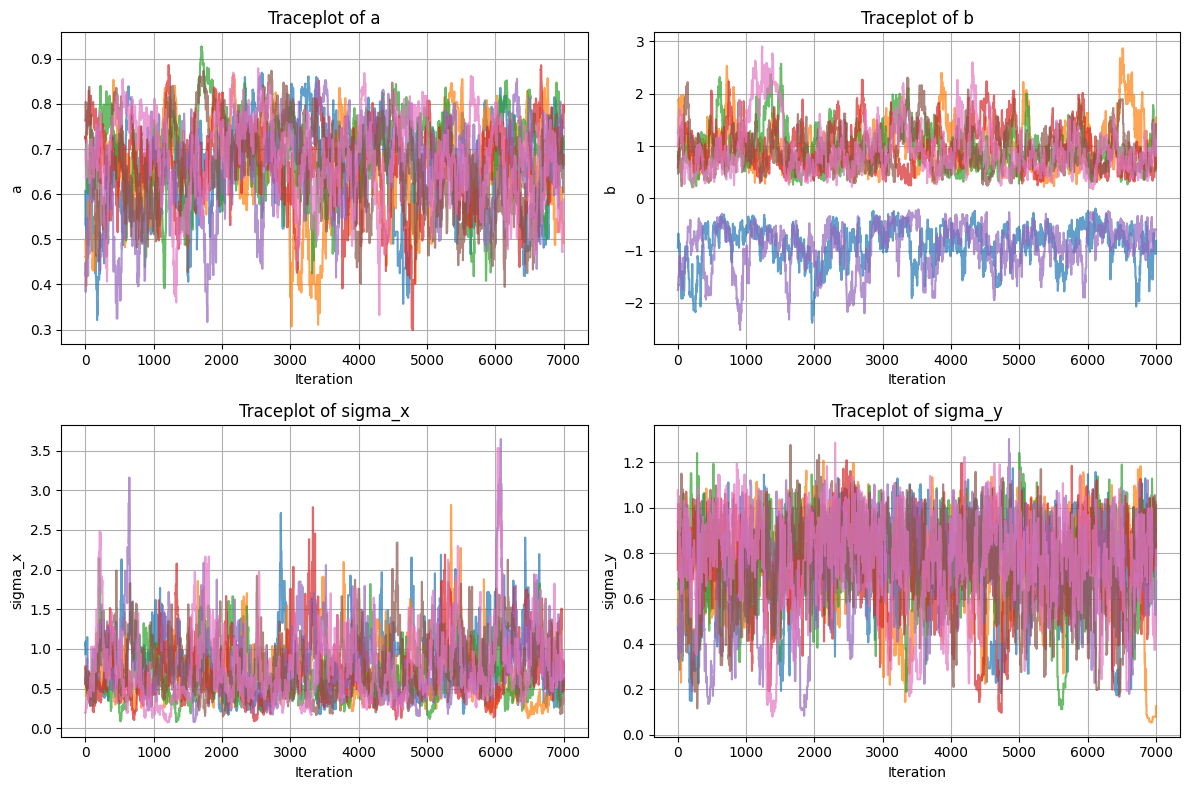

In [ ]:
# Traceplot of parameters
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    if chain == 0:
        continue       # Skip the 1st chain which seems to have diverged
    _, _, thetas, _ = results_bpf[chain]
    thetas_post_burnin = {key: values[burn_in:] for key, values in thetas.items()}
    for i, key in enumerate(thetas_post_burnin.keys()):
        plt.subplot(2, 2, i+1)
        plt.plot(thetas_post_burnin[key], label=f"Chain {chain+1}", alpha=0.7)
        plt.title(f'Traceplot of {key}')
        plt.xlabel('Iteration')
        plt.ylabel(key)
        plt.grid()
plt.tight_layout()
plt.show()

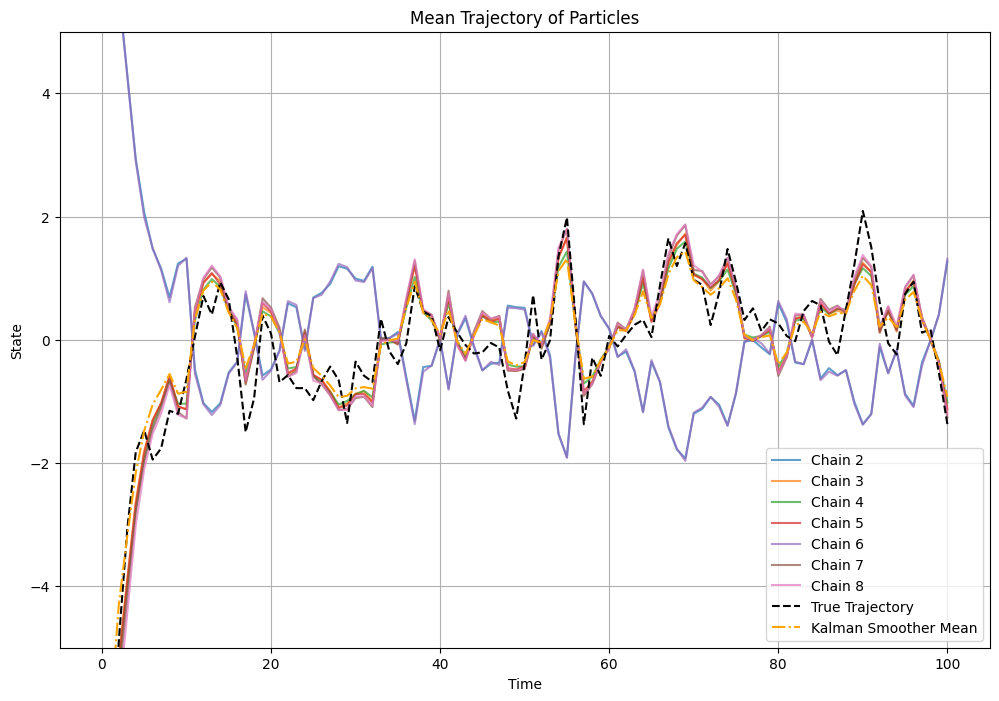

In [122]:
# Now let's look at samples of trajectories
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    if chain == 0:
        continue       # Skip the 1st chain which seems to have diverged
    samples, _, _, _ = results_bpf[chain]
    # Compute mean trajectory post burn-in
    samples_post_burnin = samples[burn_in:]
    np_samples_post_burnin = np.array([[state.x_t for state in sample] for sample in samples_post_burnin])
    mean_trajectory = np.mean(np_samples_post_burnin, axis=0)
    plt.plot(mean_trajectory, label=f"Chain {chain+1}", alpha=0.7)
plt.plot(np.arange(1, len(x_true)+1), x_true, label="True Trajectory", color='black', linestyle='--')
plt.plot(np.arange(1, len(mu_smooth)+1), mu_smooth, label="Kalman Smoother Mean", color='orange', linestyle='-.')
plt.xlabel("Time")
plt.ylabel("State")
plt.title("Mean Trajectory of Particles")
plt.legend()
plt.grid()
plt.ylim(-5, 5)
plt.show()

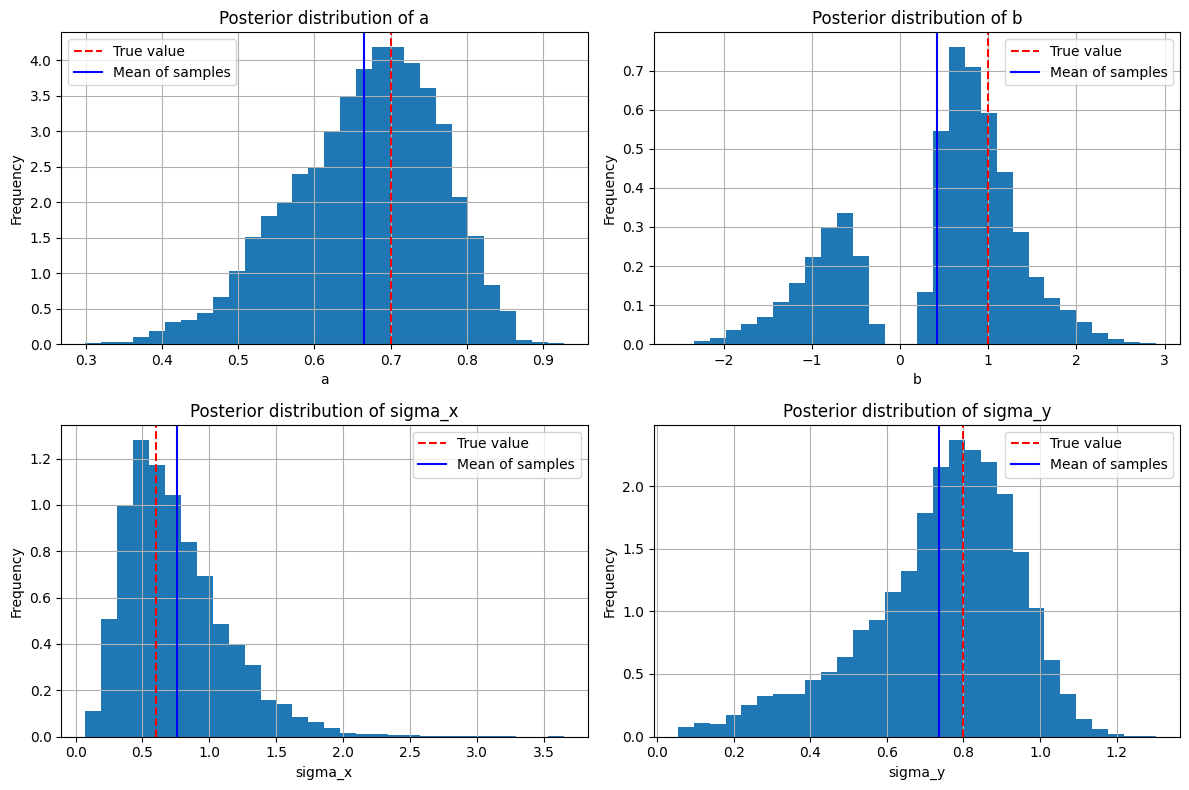

In [123]:
# Plot distribution of parameters post burn-in
chain_thetas = []
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    if chain == 0:
        continue       # Skip the 1st chain which seems to have diverged
    _, _, thetas, _ = results_bpf[chain]
    thetas_post_burnin = {key: values[burn_in:] for key, values in thetas.items()}
    chain_thetas.append(thetas_post_burnin)
for key in chain_thetas[0].keys():
    plt.subplot(2, 2, list(chain_thetas[0].keys()).index(key)+1)
    joint_samples = np.concatenate([chain_thetas[chain][key] for chain in range(len(chain_thetas))])
    plt.hist(joint_samples, bins=30, density=True)
    plt.axvline(getattr(true_theta, key), color='red', linestyle='--', label='True value')
    plt.axvline(np.mean(joint_samples), color='blue', linestyle='-', label='Mean of samples')
    plt.title(f"Posterior distribution of {key}")
    plt.xlabel(key)
    plt.ylabel("Frequency")
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

Let's explain why we observe such results. Some chains converge to approximately true parameter values, while others converge to different values. 

Chains differ in parameter $b$ to which they converge. Instead of oscillating around $1$, it oscillates around $-1$. This is the identifiability issue. 
Linear Gaussian state-space model is defined as:
$$
\begin{aligned}
x_t &= a x_{t-1} + \sigma_x \epsilon_t, \qquad \epsilon_t \sim \mathcal{N}(0, 1) \\
y_t &= b x_t + \sigma_y \eta_t, \qquad \eta_t \sim \mathcal{N}(0, 1)
\end{aligned}
$$
Now let's define transformation $\tilde{x}_t = -x_t$ and $\tilde{b} = -b$ and keeping other parameters the same. Now we can show that state equation and observation equation are invariant to this transformation:
$$
\begin{aligned}
\tilde{x}_t &= -x_t = -a x_{t-1} - \sigma_x \epsilon_t = a \tilde{x}_{t-1} + \sigma_x (-\epsilon_t) \\
y_t &= b x_t + \sigma_y \eta_t = \tilde{b} \tilde{x}_t + \sigma_y \eta_t
\end{aligned}
$$
Since $\epsilon_t$ and $-\epsilon_t$ have the same distribution, the likelihood of the data given parameters $(a, b, \sigma_x, \sigma_y)$ is the same as the likelihood given parameters $(a, -b, \sigma_x, \sigma_y)$. This means that the model cannot distinguish between these two sets of parameters based on the observed data alone. This is also reflected in the posterior distribution of latent states $x_t$, where those chains that converge correctly to $b \approx 1$ will have correct posterior distribution of $x_t$, while those that converge to $b \approx -1$ will have exactly the reflected posterior distribution of $\tilde{x}_t = -x_t$.

As a result, the posterior distribution will have two modes corresponding to these parameter sets, leading to identifiability issues.


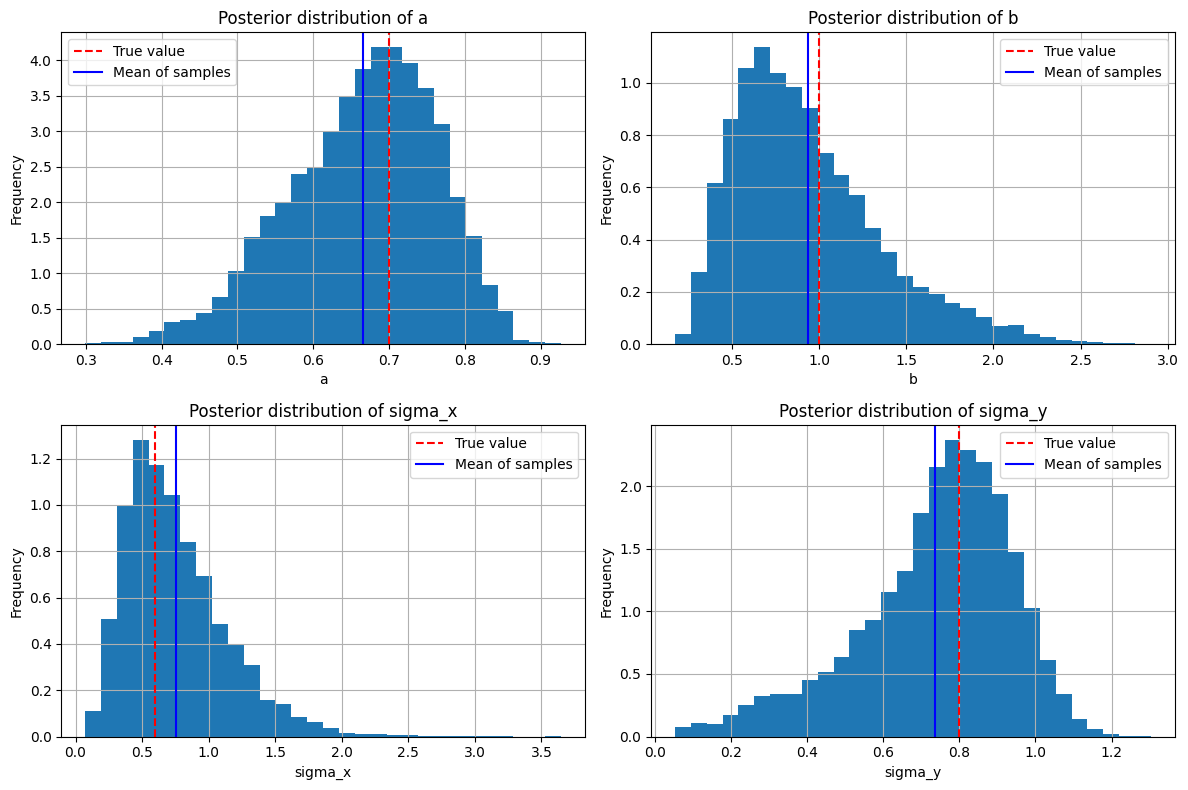

In [124]:
# Plot distribution of parameters post burn-in 
# but now take absolute value for parameter b !!
chain_thetas = []
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    if chain == 0:
        continue       # Skip the 1st chain which seems to have diverged
    _, _, thetas, _ = results_bpf[chain]
    thetas_post_burnin = {key: values[burn_in:] for key, values in thetas.items()}
    chain_thetas.append(thetas_post_burnin)
for key in chain_thetas[0].keys():
    if key == "b":
        for chain in range(len(chain_thetas)):
            chain_thetas[chain][key] = np.abs(chain_thetas[chain][key])
    plt.subplot(2, 2, list(chain_thetas[0].keys()).index(key)+1)
    joint_samples = np.concatenate([chain_thetas[chain][key] for chain in range(len(chain_thetas))])
    plt.hist(joint_samples, bins=30, density=True)
    plt.axvline(getattr(true_theta, key), color='red', linestyle='--', label='True value')
    plt.axvline(np.mean(joint_samples), color='blue', linestyle='-', label='Mean of samples')
    plt.title(f"Posterior distribution of {key}")
    plt.xlabel(key)
    plt.ylabel("Frequency")
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

Now let's check if using Auxiliary Particle Filter (APF) instead of Bootstrap Particle Filter (BPF) can improve the convergence of PMMH. We will use the same number of particles $N = 1000$ for both filters to ensure a fair comparison.

In [125]:
apf = AuxiliaryParticleFilter(model, N, resampler=systematic_resampling)

In [126]:
# Test log marginal likelihood mean and variance for fixed parameters
logmarliks_apf = []
for _ in range(1000): 
    history = apf.run(y, true_theta)
    logmarlik = history[-1][3]
    logmarliks_apf.append(logmarlik)

print(f"APF log marginal likelihood")
print(f"mean: {np.mean(logmarliks_apf)}")
print(f"variance: {np.var(logmarliks_apf)}")

print(f"\nAPF marginal likelihood")
print(f"mean: {np.mean(np.exp(logmarliks_apf))}")
print(f"variance: {np.var(np.exp(logmarliks_apf))}")

APF log marginal likelihood
mean: -146.32816140349973
variance: 0.09433952444708567

APF marginal likelihood
mean: 2.957653451280105e-64
variance: 8.645113358339843e-129


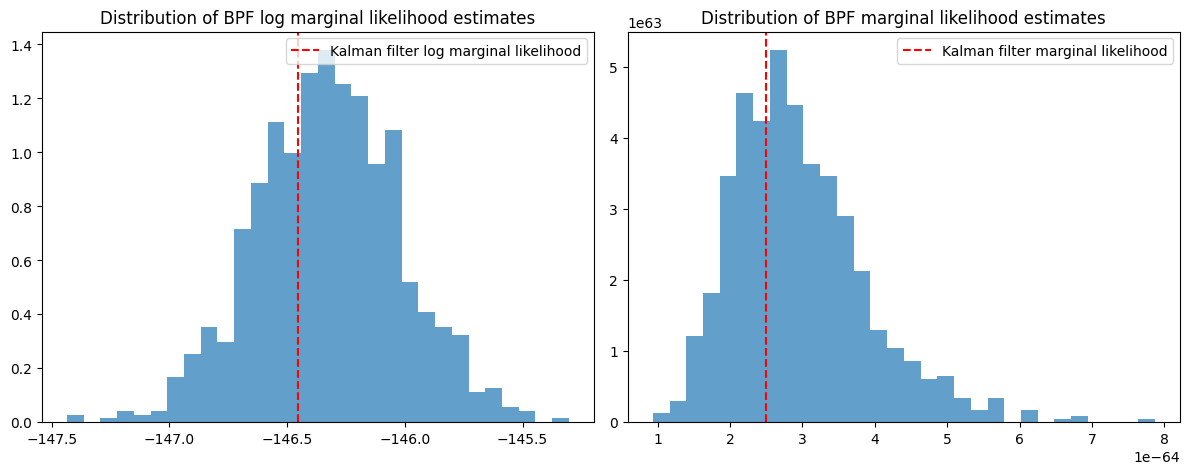

In [128]:
# Plot distribution of marginal likelihood estimates
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(logmarliks_apf, bins=30, density=True, alpha=0.7)
plt.axvline(logmarlik_kf, color='red', linestyle='--', label='Kalman filter log marginal likelihood')
plt.title("Distribution of BPF log marginal likelihood estimates")
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(np.exp(logmarliks_apf), bins=30, density=True, alpha=0.7)
plt.axvline(np.exp(logmarlik_kf), color='red', linestyle='--', label='Kalman filter marginal likelihood')
plt.title("Distribution of BPF marginal likelihood estimates")
plt.legend()
plt.tight_layout()
plt.show()

In [129]:
kwargs_for_sampling = {
    "step_a": 0.05,
    "step_b": 0.15,
    "step_sigma_x": 0.2,
    "step_sigma_y": 0.2,
}
    
pmmh = ParticleMarginalMetropolisHastings(apf, kwargs_for_sampling=kwargs_for_sampling)

In [130]:
n_chains = 8
results_apf = pmmh.run(y, n_iter=10000, n_chain=n_chains, burnin=0)

Chain 1 acceptance rate: 0.340
Chain 2 acceptance rate: 0.332
Chain 3 acceptance rate: 0.309
Chain 4 acceptance rate: 0.330
Chain 5 acceptance rate: 0.326
Chain 6 acceptance rate: 0.329
Chain 7 acceptance rate: 0.332
Chain 8 acceptance rate: 0.327


In [134]:
burn_in = 5000

In [135]:
# Print initial parameters theta for each chain
for chain in range(n_chains):
    _, _, thetas, _ = results_apf[chain]
    initial_theta = {key: values[0] for key, values in thetas.items()}
    print(f"Chain {chain+1} initial theta: {initial_theta}")

Chain 1 initial theta: {'a': np.float64(-0.7239097598341717), 'b': 0.5490753220375226, 'sigma_x': np.float64(1.2015374919327397), 'sigma_y': np.float64(0.9552760866605504)}
Chain 2 initial theta: {'a': np.float64(-0.21751034942314335), 'b': -0.867701245479898, 'sigma_x': np.float64(0.017723549996005197), 'sigma_y': np.float64(2.4998930495040863)}
Chain 3 initial theta: {'a': 0.8043134318552569, 'b': -0.6516894783100049, 'sigma_x': 0.28001019962315377, 'sigma_y': 2.273794929523547}
Chain 4 initial theta: {'a': -0.7683053837721552, 'b': 0.8337726316054102, 'sigma_x': 0.44543802320042575, 'sigma_y': 0.9879379274268396}
Chain 5 initial theta: {'a': -0.8737428397110674, 'b': 0.026469013411785636, 'sigma_x': 0.7926743555304802, 'sigma_y': 0.00452571463033579}
Chain 6 initial theta: {'a': np.float64(0.4782385492903799), 'b': -0.8314759359471918, 'sigma_x': np.float64(0.5062042105955404), 'sigma_y': np.float64(1.079589734765999)}
Chain 7 initial theta: {'a': -0.765535612437654, 'b': -0.3199846

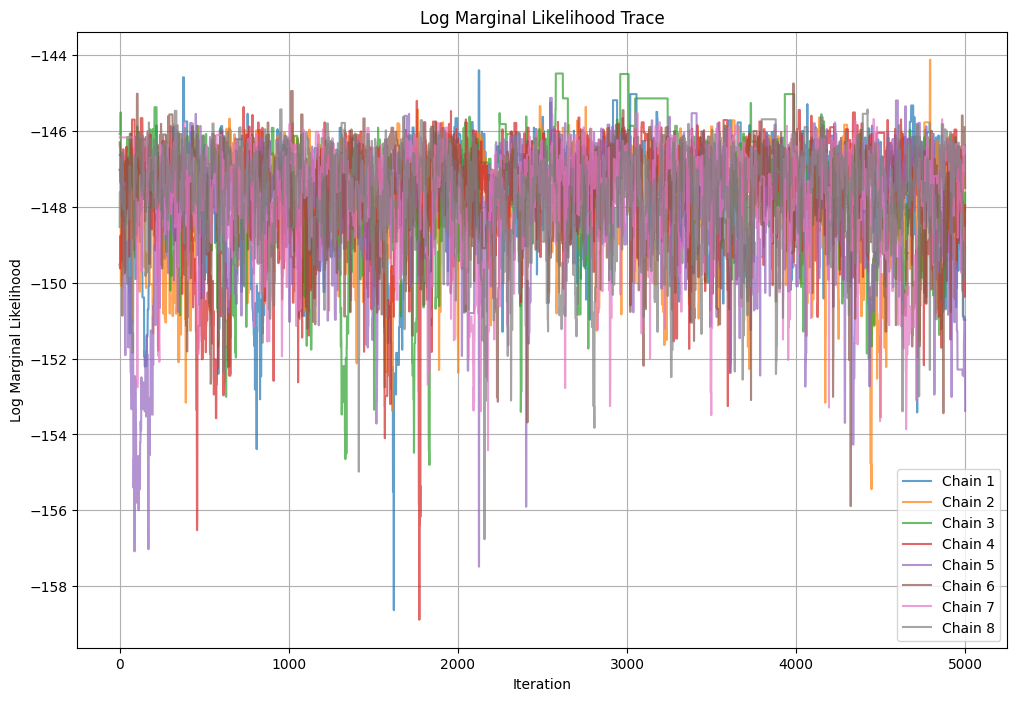

In [136]:
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    samples, logmarliks, thetas, alphas = results_apf[chain]
    plt.plot(logmarliks[burn_in:], label=f"Chain {chain+1}", alpha=0.7)
    
plt.xlabel("Iteration")
plt.ylabel("Log Marginal Likelihood")
plt.title("Log Marginal Likelihood Trace")
plt.legend()
plt.grid()
plt.show()

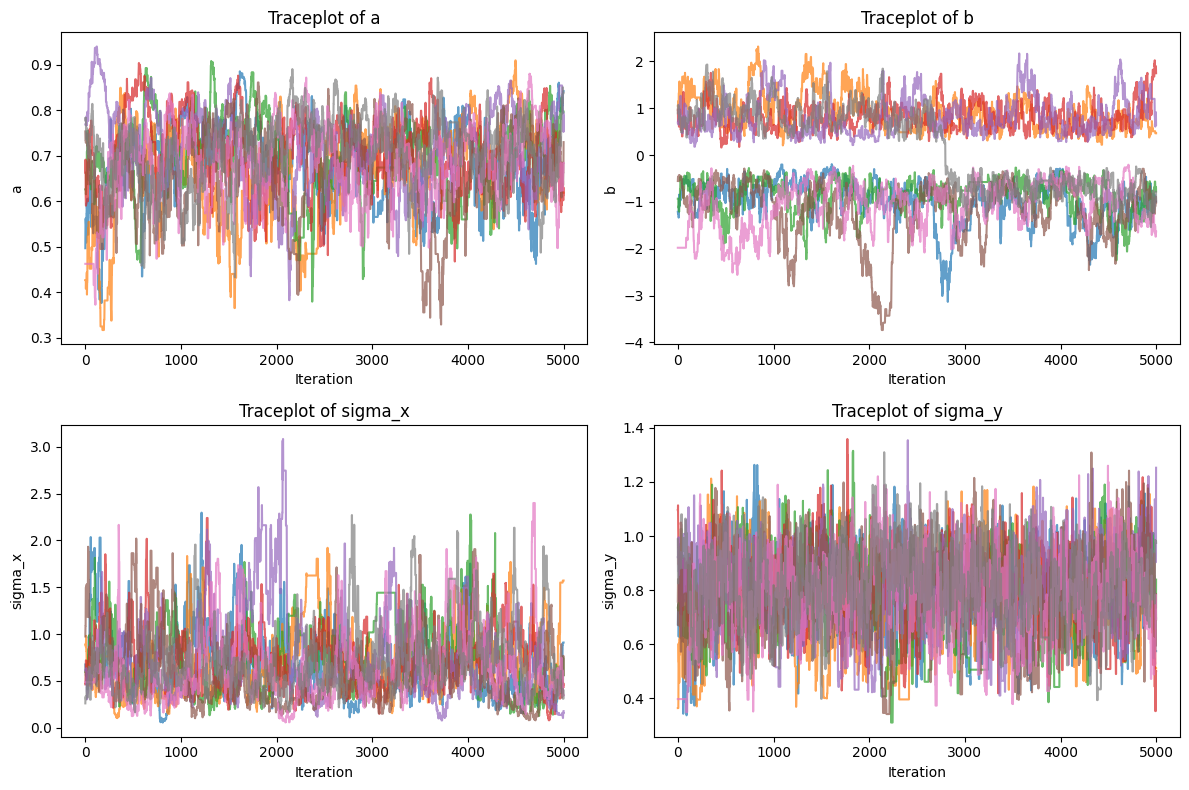

In [137]:
# Traceplot of parameters
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    _, _, thetas, _ = results_apf[chain]
    thetas_post_burnin = {key: values[burn_in:] for key, values in thetas.items()}
    for i, key in enumerate(thetas_post_burnin.keys()):
        plt.subplot(2, 2, i+1)
        plt.plot(thetas_post_burnin[key], label=f"Chain {chain+1}", alpha=0.7)
        plt.title(f'Traceplot of {key}')
        plt.xlabel('Iteration')
        plt.ylabel(key)
        plt.grid()
plt.tight_layout()
plt.show()

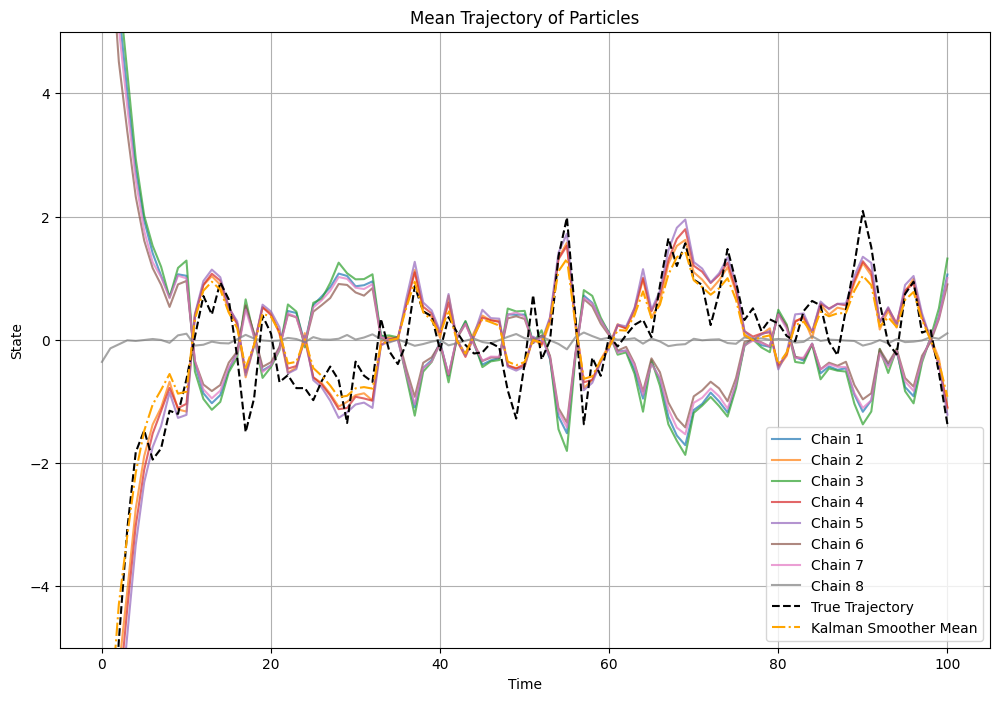

In [139]:
# Now let's look at samples of trajectories
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    samples, _, _, _ = results_apf[chain]
    # Compute mean trajectory post burn-in
    samples_post_burnin = samples[burn_in:]
    np_samples_post_burnin = np.array([[state.x_t for state in sample] for sample in samples_post_burnin])
    mean_trajectory = np.mean(np_samples_post_burnin, axis=0)
    plt.plot(mean_trajectory, label=f"Chain {chain+1}", alpha=0.7)
plt.plot(np.arange(1, len(x_true)+1), x_true, label="True Trajectory", color='black', linestyle='--')
plt.plot(np.arange(1, len(mu_smooth)+1), mu_smooth, label="Kalman Smoother Mean", color='orange', linestyle='-.')
plt.xlabel("Time")
plt.ylabel("State")
plt.title("Mean Trajectory of Particles")
plt.legend()
plt.grid()
plt.ylim(-5, 5)
plt.show()

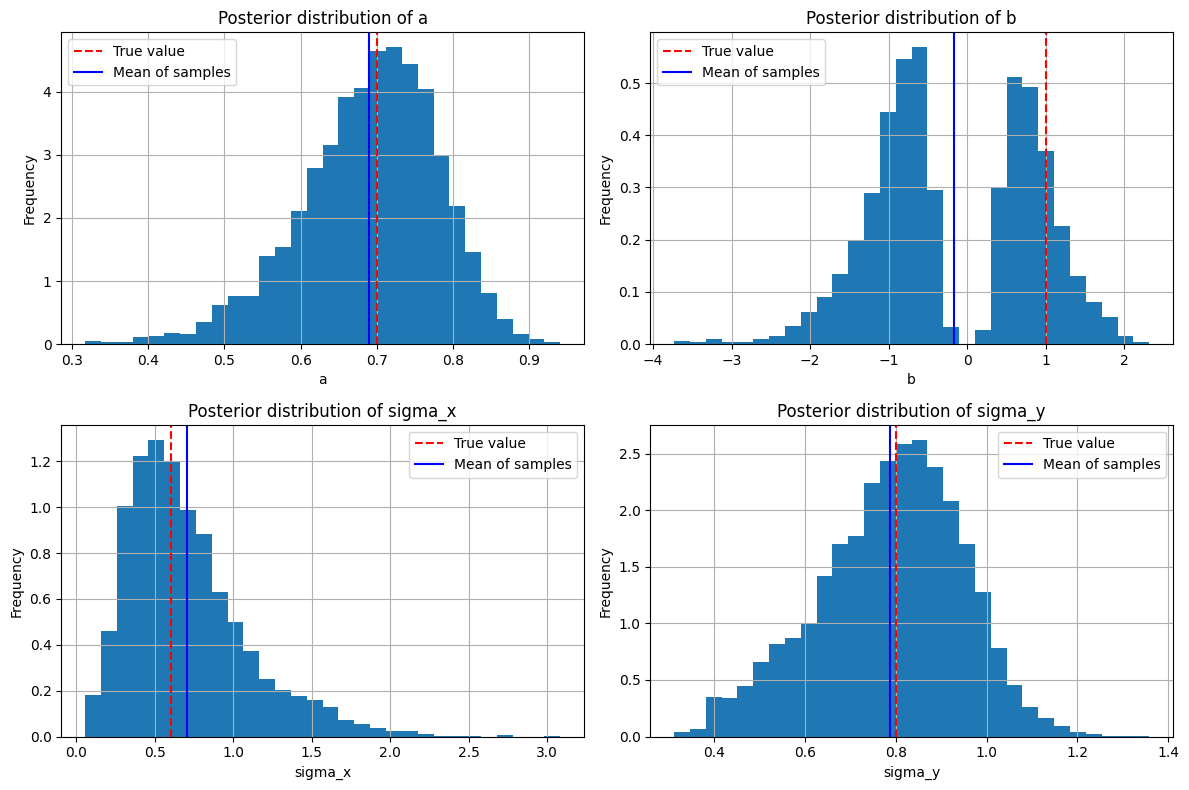

In [140]:
# Plot distribution of parameters post burn-in
chain_thetas = []
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    _, _, thetas, _ = results_apf[chain]
    thetas_post_burnin = {key: values[burn_in:] for key, values in thetas.items()}
    chain_thetas.append(thetas_post_burnin)
for key in chain_thetas[0].keys():
    plt.subplot(2, 2, list(chain_thetas[0].keys()).index(key)+1)
    joint_samples = np.concatenate([chain_thetas[chain][key] for chain in range(len(chain_thetas))])
    plt.hist(joint_samples, bins=30, density=True)
    plt.axvline(getattr(true_theta, key), color='red', linestyle='--', label='True value')
    plt.axvline(np.mean(joint_samples), color='blue', linestyle='-', label='Mean of samples')
    plt.title(f"Posterior distribution of {key}")
    plt.xlabel(key)
    plt.ylabel("Frequency")
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

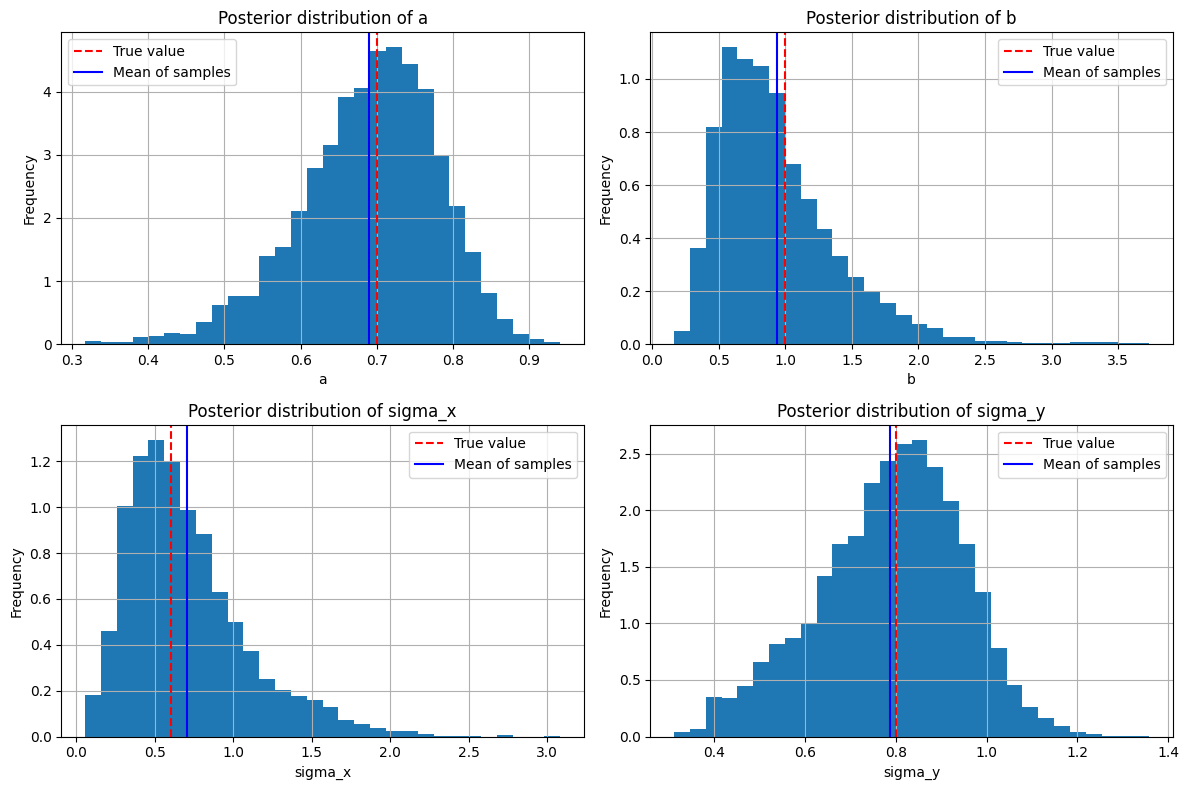

In [141]:
# Again plot distribution of parameters post burn-in but now take absolute value for parameter b !!
chain_thetas = []
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    _, _, thetas, _ = results_apf[chain]
    thetas_post_burnin = {key: values[burn_in:] for key, values in thetas.items()}
    chain_thetas.append(thetas_post_burnin)
for key in chain_thetas[0].keys():
    if key == "b":
        for chain in range(len(chain_thetas)):
            chain_thetas[chain][key] = np.abs(chain_thetas[chain][key])
    plt.subplot(2, 2, list(chain_thetas[0].keys()).index(key)+1)
    joint_samples = np.concatenate([chain_thetas[chain][key] for chain in range(len(chain_thetas))])
    plt.hist(joint_samples, bins=30, density=True)
    plt.axvline(getattr(true_theta, key), color='red', linestyle='--', label='True value')
    plt.axvline(np.mean(joint_samples), color='blue', linestyle='-', label='Mean of samples')
    plt.title(f"Posterior distribution of {key}")
    plt.xlabel(key)
    plt.ylabel("Frequency")
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()